In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

tqdm.pandas()
sns.set_style('dark')
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 14

In [ ]:
data = pd.read_csv("/content/shopee_reviews.csv", encoding='latin1')
data = data.sample(100000).reset_index(drop=True)
data.head()

,label,text
0,5,Thanks seller for the prompt delivery. Much ap...
1,5,Received items within 2 weeks. Good packaging....
2,5,Good price of 99c during 11.11 sales. Received...
3,5,Received..thnk u!!ð
4,5,Bigger than expected but my sister and i loved...


In [ ]:
def text_cleaning(x):

    text = re.sub('\s+\n+', ' ', x)
    text = re.sub('[^a-zA-Z0-9\.]', ' ', text)
    text = text.split()

    text = [word for word in text]
    text = ' '.join(text)
    text = 'startseq '+text+' endseq'

    return text

In [ ]:
data['text'] = data['text'].progress_apply(text_cleaning)

100%|██████████| 100000/100000 [00:01<00:00, 51088.96it/s]


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

In [ ]:
train = data.iloc[:85000, :]
val = data.iloc[85000:95000, :].reset_index(drop=True)
test = data.iloc[95000:, :].reset_index(drop=True)

In [ ]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train['text'].tolist())
max_length = max(len(caption.split()) for caption in train['text'].tolist())

In [ ]:
df_vocab = pd.DataFrame(list(tokenizer.word_counts.items()), columns=['word','count'])
df_vocab.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)
df_vocab.head()

,word,count
0,startseq,85000
1,endseq,85000
2,the,44323
3,good,36574
4,and,36308


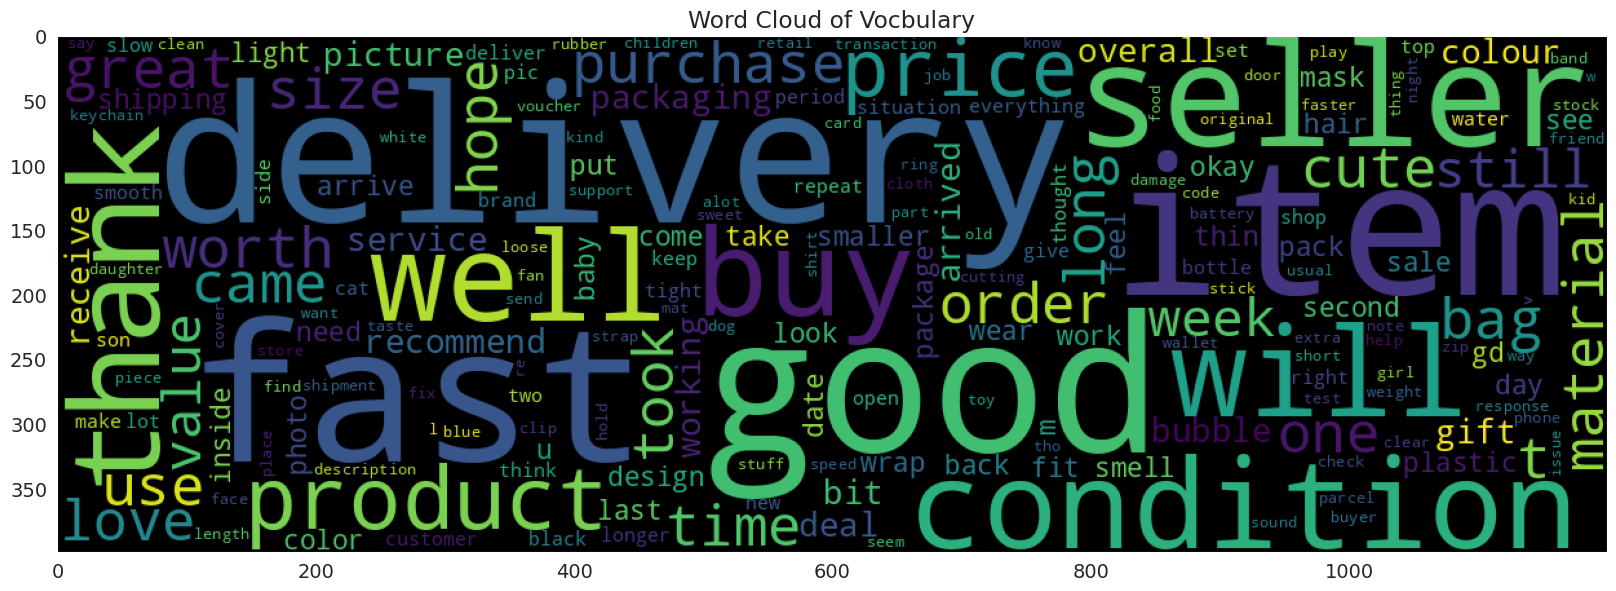

In [ ]:
words = ""
words += " ".join(df_vocab['word'].tolist())+" "
wordcloud = WordCloud(width = 1200, height = 400,
                background_color ='black',
                min_font_size = 10).generate(words)

plt.imshow(wordcloud)
plt.title('Word Cloud of Vocbulary')
plt.show()

In [ ]:
df_vocab.describe()

,count
count,18377.000000
mean,77.960168
std,1219.451863
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,85000.000000


In [ ]:
df_vocab[df_vocab['count']>=50]

,word,count
0,startseq,85000
1,endseq,85000
2,the,44323
3,good,36574
4,and,36308
...,...,...
1571,suits,50
1572,washed,50
1573,professional,50
1574,crack,50


In [ ]:
vocab_size = len(df_vocab[df_vocab['count']>=50])
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train['text'].tolist())

In [ ]:
data['length'] = data['text'].progress_apply(lambda x: len(x.split(' ')))

100%|██████████| 100000/100000 [00:00<00:00, 450753.73it/s]


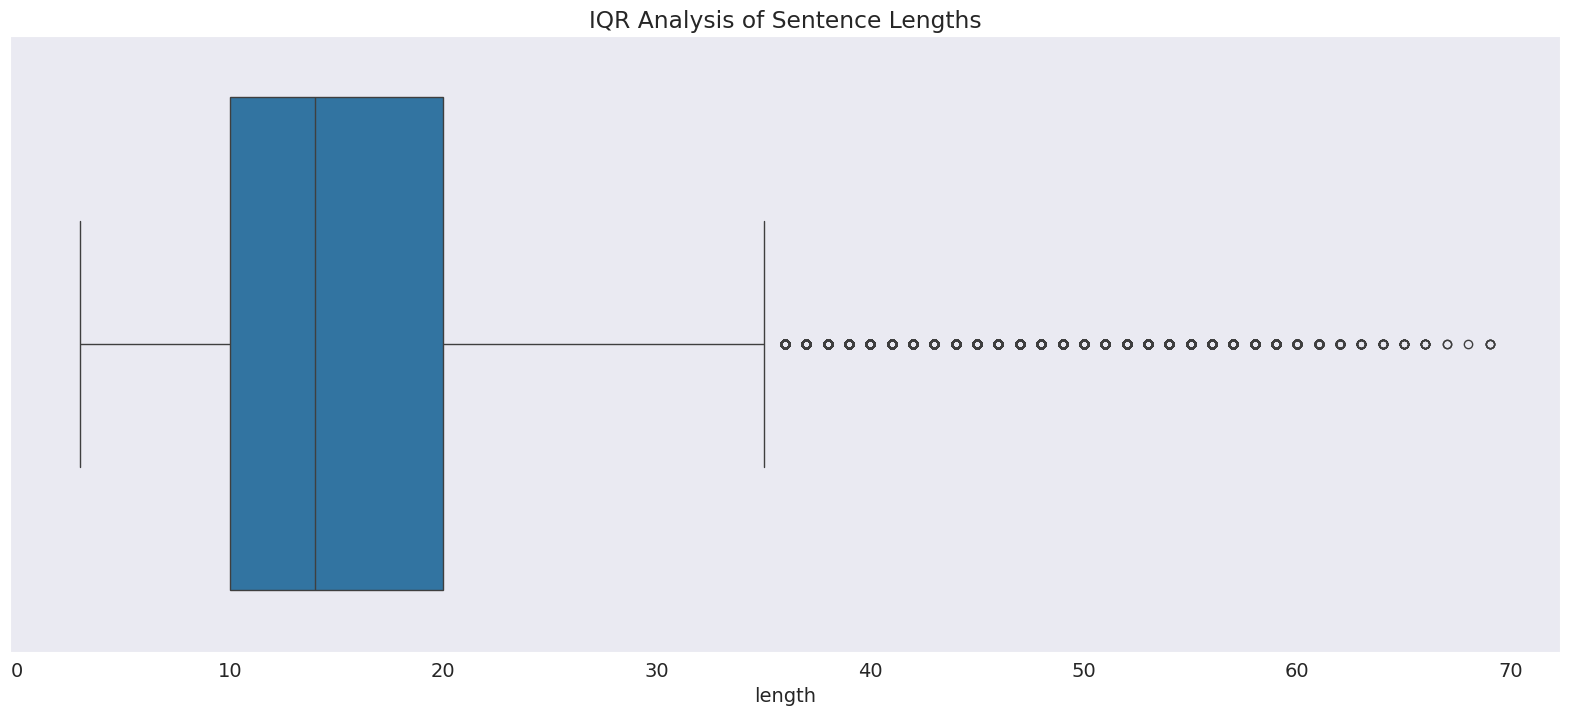

In [ ]:
sns.boxplot(x='length', data=data)
plt.title('IQR Analysis of Sentence Lengths')
plt.show()

In [ ]:
data.describe()

,label,length
count,100000.000000,100000.000000
mean,4.778000,16.844060
std,0.700358,10.339692
min,1.000000,3.000000
25%,5.000000,10.000000
50%,5.000000,14.000000
75%,5.000000,20.000000
max,5.000000,69.000000


In [ ]:
max_length = 50
print(train.loc[0, 'text'])
print(tokenizer.texts_to_sequences([train.loc[0, 'text']])[0])

startseq Thanks seller for the prompt delivery. Much appreciated. endseq
[2, 39, 19, 14, 4, 135, 10, 87, 1351, 3]


In [ ]:
seq = train.loc[0, 'text'].split()
X, y = [], []
for i in range(1,len(seq)):
    in_seq, out_seq = seq[:i], seq[i]
    X.append(' '.join(in_seq))
    y.append(out_seq)

example = pd.DataFrame(columns=['input','output'])
example['input'] = X
example['output'] = y
example


,input,output
0,startseq,Thanks
1,startseq Thanks,seller
2,startseq Thanks seller,for
3,startseq Thanks seller for,the
4,startseq Thanks seller for the,prompt
5,startseq Thanks seller for the prompt,delivery.
6,startseq Thanks seller for the prompt delivery.,Much
7,startseq Thanks seller for the prompt delivery...,appreciated.
8,startseq Thanks seller for the prompt delivery...,endseq


In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, batch_size, tokenizer, vocab_size, max_length, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X, y = self.__get_data(batch)
        return X, y

    def __get_data(self,batch):

        X, y = list(), list()
        captions = batch.loc[:, self.X_col].tolist()
        for caption in captions:
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            max_len = self.max_length if len(seq) > self.max_length else len(seq)
            for i in range(1,max_len):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X.append(in_seq)
                y.append(out_seq)

        X, y = np.array(X), np.array(y)

        return X, y

In [ ]:
train_gen = CustomDataGenerator(train, 'text', 16, tokenizer, vocab_size, max_length)
val_gen = CustomDataGenerator(val, 'text', 16, tokenizer, vocab_size, max_length)
test_gen = CustomDataGenerator(test, 'text', 16, tokenizer, vocab_size, max_length)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Embedding, LSTM, add, Concatenate, Reshape,
                                     concatenate, Bidirectional, Dense, Input)

In [ ]:
input_layer = Input(shape=(50,))
x = Embedding(vocab_size, 64)(input_layer)
x = Bidirectional(LSTM(100))(x)
output_layer = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=[input_layer], outputs=output_layer)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam())

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 64)            100864    
                                                                 
 bidirectional (Bidirection  (None, 200)               132000    
 al)                                                             
                                                                 
 dense (Dense)               (None, 1576)              316776    
                                                                 
Total params: 549640 (2.10 MB)
Trainable params: 549640 (2.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

es = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr * tf.math.exp(-0.1*epoch)


lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=25, callbacks=[checkpoint, es, lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/7
5312/5312 [==============================] - ETA: 0s - loss: 4.3332
Epoch 1: val_loss improved from inf to 3.96739, saving model to model.h5
5312/5312 [==============================] - 2266s 426ms/step - loss: 4.3332 - val_loss: 3.9674 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/7
5312/5312 [==============================] - ETA: 0s - loss: 3.8599
Epoch 2: val_loss improved from 3.96739 to 3.80804, saving model to model.h5
5312/5312 [==============================] - 2265s 426ms/step - loss: 3.8599 - val_loss: 3.8080 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/7
5312/5312 [==============================] - ETA: 0s - loss: 3.7401
Epoch 3: val_loss improved from 3.80804 to 3.73614, saving model to model.h5
5312/5312 [==============================] - 2303s 434ms/step - loss: 3.7401 - val_loss: 3.7361 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/7
5312/5312 [==============================] - ETA: 0s - loss: 3.6716
Epoch 4: val_loss improved from 3.73614 to 3.68792, saving model to model.h5
5312/5312 [==============================] - 2230s 420ms/step - loss: 3.6716 

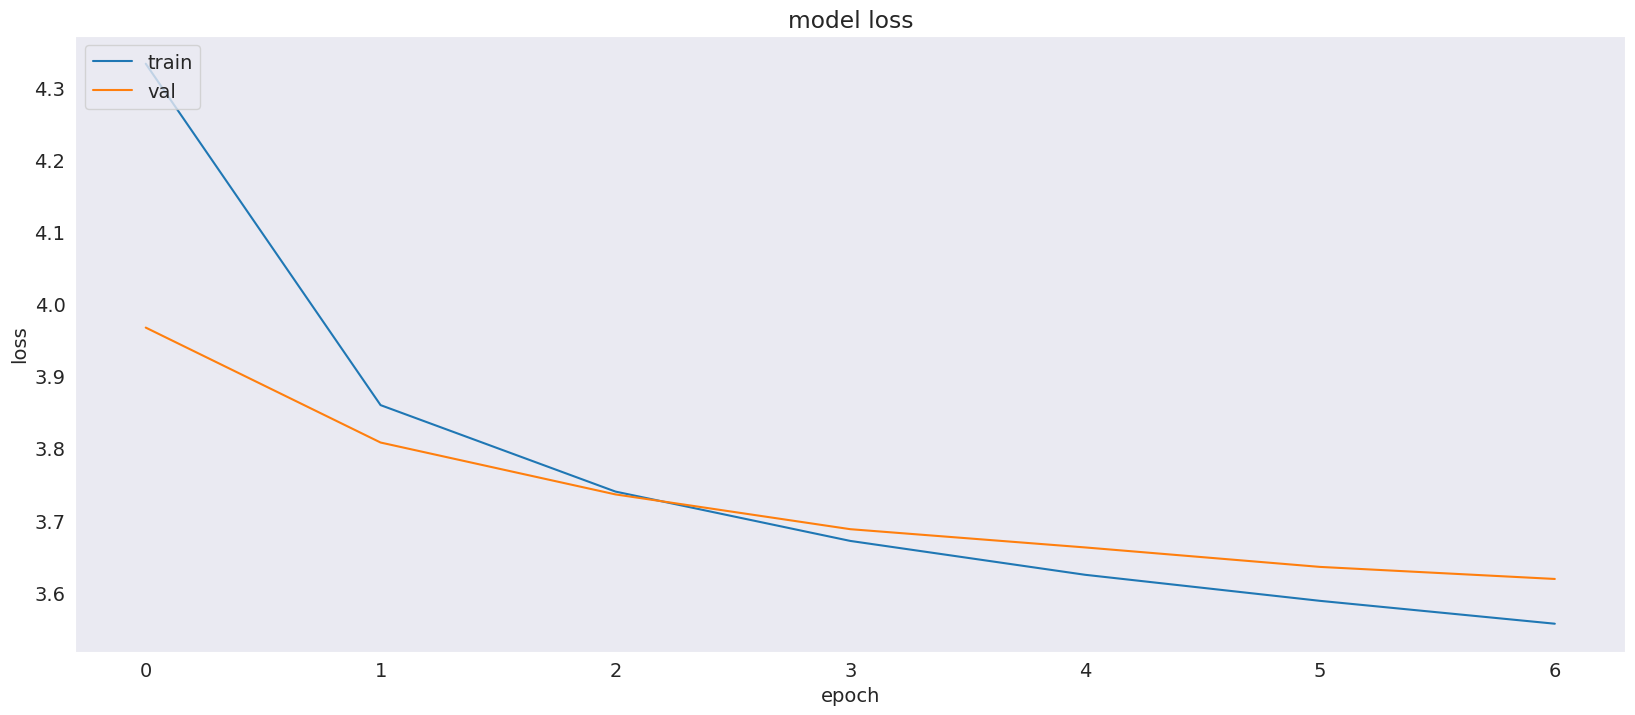

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_sentence(text, model, tokenizer, max_length):

    in_text = "startseq " + text
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict(sequence, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
def beam_search_predictions(text, beam_index = 3):
    in_text = "startseq " + text
    start = tokenizer.texts_to_sequences([in_text])[0]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length)
            preds = model.predict(par_caps, verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [idx_to_word(i, tokenizer) for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:

sentences = ["overall the product is okay",
             "exactly like picture",
             "price could have been cheaper",
             "will recommend this item",
             "useful packaging"]

for sentence in sentences:
    print("Greedy Search: ", predict_sentence(sentence, model, tokenizer, 50))
    print("Beam Search: ", beam_search_predictions(sentence))
    print("\n")

Greedy Search:  startseq overall the product is okay endseq
Beam Search:  overall the product is okay for the price paid for the price paid for the price paid for the price paid for the price paid for the price paid for the price paid for the price paid for the price paid for the price paid for the price paid


Greedy Search:  startseq exactly like picture and the quality is good endseq
Beam Search:  exactly like picture shown in the picture


Greedy Search:  startseq price could have been cheaper than retail price is good endseq
Beam Search:  price could have been cheaper than retail price is cheaper than retail shop


Greedy Search:  startseq will recommend this item endseq
Beam Search:  will recommend this item to my friends


Greedy Search:  startseq useful packaging and <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV